In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random 
from mpl_toolkits.mplot3d import Axes3D
random.seed('foobar')
np.random.seed(30)

# Mesona intrinsic matrix
K_m = np.array([[1.4219, 0.0005, 0.5092],
             [0, 1.4219, 0.3802],
             [0, 0, 0.0010]])
K_m = K_m / K_m[-1, -1]

# statue intrinsic matrix
K1_s = np.array([[5426.566895, 0.678017, 330.096680],
                 [0.000000, 5423.133301, 648.950012],
                 [0.000000, 0.000000, 1.000000]])
K2_s = np.array([[5426.566895, 0.678017, 387.430023],
                 [0.000000, 5423.133301, 620.616699],
                 [0.000000, 0.000000, 1.000000]])
R1_s = np.array([[0.140626, 0.989027, -0.045273],
               [0.475766, -0.107607, -0.872965],
               [-0.868258, 0.101223, -0.485678]])

t1_s = np.array([67.479439, -6.020049, 40.224911])

R2_s = np.array([[0.336455, 0.940689, -0.043627],
               [0.446741, -0.200225, -0.871970],
               [-0.828988, 0.273889, -0.487611]])

t2_s = np.array([62.882744, -21.081516, 40.544052])

In [2]:
# split the file name and return name without the type
def split_str(file_name):
    
    print (file_name.split('.'))
    
    return file_name.split('.')[0];

# read image one and two
def read_image(file_name, img_input_path):
    
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
        img_name = split_str(file_name)
        img = cv2.imread(img_input_path+file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        return img_name, img

In [3]:
def sift_detector( im1, im2):
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    pts1 = []
    pts2 = []
    
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
	
    return pts1,pts2,good	

In [4]:
def get_normalize(x1, x2, shape1, shape2):
    '''
    normalize (x, y) coordinate to -1~1 and get the transformation matrix
    '''
    #print("x1",x1[:,0:2].shape)# (402,2)
    #print(shape1)
    ones = np.ones(x1.shape[0]).reshape(-1, 1)
    x1 = np.concatenate((x1, ones), axis=1).T
    x2 = np.concatenate((x2, ones), axis=1).T
    #print("x1",x1.shape)
    T1 = np.array([[2/shape1[1], 0, -1],
                   [0, 2/shape1[0], -1],
                   [0, 0, 1]])
    T2 = np.array([[2/shape2[1], 0, -1],
                   [0, 2/shape2[0], -1],
                   [0, 0, 1]])
    x1 = np.dot(T1, x1)
    x2 = np.dot(T2, x2)
    #print("x1",x1.shape)
    #print("new pts min and max: ",np.min(x1),np.max(x1))
    return x1, x2, T1, T2

# ref: https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py
def get_fundamental(x1, x2, T1, T2):
    # x1 = [u v 1] x2 = [u' v' 1]
    best_F = np.zeros((3,3))
    ransac_iter = 2000
    threshold_distance = 0.000005
    thre_inlier = 0
    sample = x1[0].shape[0]
    #print(x1[0].shape)
    for iter in range(ransac_iter):
        indexes = random.sample(range(x1[0].shape[0]), 8)   
        A = []
        inlier = 0
        for i in indexes:
            #[ uu' vu' u' uv' vv' v' u v 1]
            A.append([x1[0][i]*x2[0][i], x1[1][i]*x2[0][i], x1[2][i]*x2[0][i],
                      x1[0][i]*x2[1][i], x1[1][i]*x2[1][i], x1[2][i]*x2[1][i],
                      x1[0][i]*x2[2][i], x1[1][i]*x2[2][i], x1[2][i]*x2[2][i]])
        A = np.array(A)
        #print (A)
        U,S,V = np.linalg.svd(A)
        F = V[-1].reshape(3,3)
        #print("U\n", U, "\nU[-1]\n" ,U[:,-1])
        U,S,V = np.linalg.svd(F)
        #print("diag", S)
        S[2] = 0
        #print("diag", np.diag(S))
        F = np.dot(U, np.dot(np.diag(S), V))
        # sampson distance
        Fx1 = np.dot(F.T,x1)
        Fx2 = np.dot(F,x2)
        denom = Fx1[0]**2+Fx1[1]**2+Fx2[0]**2+Fx2[1]**2
        sampson = np.diag( np.dot(x2.T, np.dot(F,x1)) )**2/denom
        #error = np.sum( np.multiply(x2,l),0 )
        #print("error  ",(abs(error)))
        m=[]
        for j in range (sampson.shape[0]):
            if sampson[j]<= threshold_distance:
                inlier = inlier+1
                m.append(1)
            else:
                m.append(0)
                				
        
        if inlier>thre_inlier:
            #Denormalized
            F = np.dot(T2.T,np.dot(F,T1))
            best_F = F
            thre_inlier = (inlier)
            mask = np.array(m)
            print("inlier: ",inlier, "x1_shape", mask.shape)
                
    return best_F/best_F[-1, -1], mask

In [5]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c, d = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def plot_Epilines(pts1, pts2, F, img1, img2):
    # drawing lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    imgc1 = img1.copy()
    imgc2 = img2.copy()
    img5,img6 = drawlines(imgc1, imgc2, lines1, pts1 ,pts2)

    # drawing lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    imgc1 = img1.copy()
    imgc2 = img2.copy()
    img3,img4 = drawlines(imgc2,imgc1,lines2,pts2,pts1)

    return img3, img5

['Mesona1', 'JPG']
['Mesona2', 'JPG']


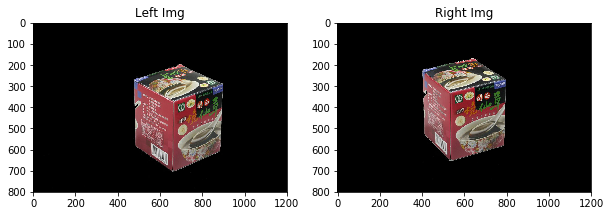

In [23]:
img_input_path = './input/'
img_output_path = './output/'

files_name = ['Mesona1.JPG', 'Mesona2.JPG', 'Statue1.bmp', 'Statue2.bmp']

img_name_1, img1 = read_image(files_name[0], img_input_path)
img_name_2, img2 = read_image(files_name[1], img_input_path)

# img_name_1, img1 = read_image(files_name[2], img_input_path)
# img_name_2, img2 = read_image(files_name[3], img_input_path)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(img1)
ax[0].title.set_text('Left Img')
ax[1].imshow(img2)
ax[1].title.set_text('Right Img')

inlier:  130 x1_shape (585,)
inlier:  146 x1_shape (585,)
inlier:  173 x1_shape (585,)
inlier:  256 x1_shape (585,)
inlier:  288 x1_shape (585,)
inlier:  420 x1_shape (585,)
inlier:  431 x1_shape (585,)
inlier:  440 x1_shape (585,)
F_cv
 [[  1.86410829e-07   2.30476146e-07  -2.19037936e-03]
 [ -1.90365249e-06   3.46551068e-07   2.03506854e-02]
 [  1.22227393e-03  -1.90465565e-02   1.00000000e+00]]
F
 [[ -1.15113852e-07  -2.91000658e-06  -1.26728556e-03]
 [  2.21076368e-06  -2.86354681e-08   1.60328990e-02]
 [  4.54050683e-04  -1.54425019e-02   1.00000000e+00]]


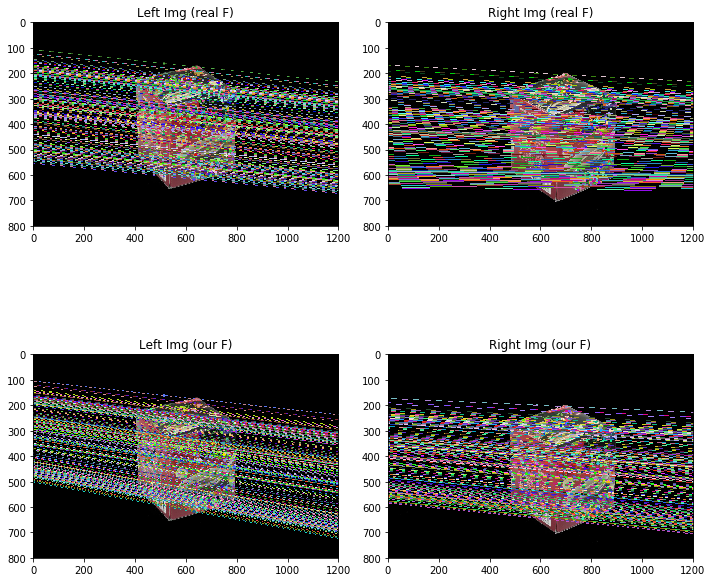

In [24]:
pts1, pts2, matches = sift_detector(img1,img2)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F_cv, mask_cv = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
n_pts1, n_pts2, T1, T2 = get_normalize(pts1, pts2, img1.shape, img2.shape) #img1.shape = (height, width)
F, mask = get_fundamental(n_pts1, n_pts2, T1, T2)
print ("F_cv\n", F_cv)
print ("F\n", F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
	
	
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
img3, img4 = plot_Epilines(pts1, pts2, F_cv, img1, img2)
ax[0][0].imshow(img3)
ax[0][1].imshow(img4)
ax[0][0].title.set_text('Left Img (real F)')
ax[0][1].title.set_text('Right Img (real F)')

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
img3, img4 = plot_Epilines(pts1, pts2, F, img1, img2)
ax[1][0].imshow(img3)
ax[1][1].imshow(img4)
ax[1][0].title.set_text('Left Img (our F)')
ax[1][1].title.set_text('Right Img (our F)')

plt.tight_layout()

In [10]:
def compute_epipole(F):
    """ Computes the (right) epipole from a 
        fundamental matrix F. 
        (Use with F.T for left epipole.) """
    
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

def E_from_F(F, K1, K2):
    """ Compute essential matrix from fundamental matrix. """
    E = (K1.T).dot(F).dot(K2)

    return E

def compute_P(E):
    """    Computes the second camera matrix (assuming P1 = [I 0]) 
        from an essential matrix. Output is a list of four 
        possible camera matrices. """

    P1 = np.eye(3)
    P1 = np.hstack((P1, np.zeros(3).reshape(-1, 1)))
    # make sure E is rank 2
    U,S,V = np.linalg.svd(E)
    if np.linalg.det(np.dot(U,V))<0:
        V = -V
    E = np.dot(U,np.dot(np.diag([1,1,0]),V))    
    
    # create matrices (Hartley p 258)
    Z = skew([0,0,-1])
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    
    # return all four solutions
    P2 = [np.vstack((np.dot(U,np.dot(W,V)).T,U[:,2])).T,
             np.vstack((np.dot(U,np.dot(W,V)).T,-U[:,2])).T,
            np.vstack((np.dot(U,np.dot(W.T,V)).T,U[:,2])).T,
            np.vstack((np.dot(U,np.dot(W.T,V)).T,-U[:,2])).T]

    return P1, P2


In [13]:
def skew(t):
    t_new = np.array([[0, -t[2], t[1]],
                      [t[2], 0, -t[0]],
                      [-t[1], t[0], 0]])
    return t_new

# ref: https://www.cvg.ethz.ch/teaching/2010fall/compvis/assignments/Exercise3b.pdf
def get_tR(E):
    w = np.array([[0.0, -1.0, 0.0],
                 [1.0, 0.0, 0.0],
                 [0.0, 0.0, 1.0]])
    z = np.array([[0.0, 1.0, 0.0], 
                  [-1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0]])
    
    U, S, V = np.linalg.svd(E)
    S[0] = (S[0] + S[1]) / 2
    S[1] = S[0]
    S[2] = 0
    
    t = U.dot(z).dot(U.T)
    t = np.array([-t[1, 2], t[0, 2], -t[0, 1]])
    
    R1 = U.dot(w.T.dot(V))
    R2 = U.dot(w.dot(V))
    
    if np.linalg.det(R1) == -1.0:
        R1 = R1 * (-1.0)
        R2 = R2 * (-1.0)
    
    return t, R1, R2

def get_cameraM(K, P1):
    return np.hstack((K, P1))

In [15]:
# Mesona1
if img_name_1 == 'Mesona1':
    print('Mesona')
    E = E_from_F(F, K_m, K_m)
    E = E_from_F(F_cv, K_m, K_m)
    t, R1, R2 = get_tR(E)
    print('E:\n', E)
    print('\nt:', t)
    print('\nR1:\n', R1, '\n\nR2:\n', R2)
    P1, P2 = compute_P(E)
    cameraM = get_cameraM(K_m, P1)
    print('\ncameraM:\n', cameraM)
else:
    # statue K
    print('statue')
    E_cv = E_from_F(F_cv, K1_s, K2_s)
    print('E_cv:\n', E_cv)
    E = E_from_F(F, K1_s, K2_s)
    print('E_cal:\n', E)
    # Calculating from real Rotation and translation matrix.
    E_real = np.dot(skew(t1_s), R1_s)
    print("E_real:\n", E_real)
    t, R1, R2 = get_tR(E_real)
    print('\nt:', t)
    print('\nR1:\n', R1, '\n\nR2:\n', R2)
    P1, P2 = compute_P(E_real)
    cameraM = get_cameraM(K1_s, P1)
    print('\ncameraM:\n', cameraM)

statue
E_cv:
 [[  4.97599802e-02  -1.93672804e+01  -1.10062054e+01]
 [ -5.10309612e+00   1.17289723e+01  -1.43783865e+02]
 [ -3.20410212e+00   1.47040113e+02  -2.59070275e-01]]
E_cal:
 [[   9.09774203 -104.77483004   -4.64828774]
 [  66.69267544    2.6418986  -162.22223792]
 [ -11.12904588  165.30286531   -0.48822575]]
E_real:
 [[-13.9106893    3.71911458  38.03874479]
 [ 64.24623108  32.9530518   30.95217658]
 [ 32.95099819  -1.30726899 -59.17973415]]

t: [-0.85645398  0.0764069  -0.51053752]

R1:
 [[-0.75588539  0.56450559 -0.33161832]
 [-0.42087658 -0.03098839  0.90658845]
 [ 0.50149793  0.82484736  0.26101085]] 

R2:
 [[ 0.14062654  0.9890271  -0.04527216]
 [ 0.47576572 -0.10760706 -0.87296489]
 [-0.86825754  0.10122309 -0.4856776 ]]

cameraM:
 [[  5.42656689e+03   6.78017000e-01   3.30096680e+02   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.42313330e+03   6.48950012e+02   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.0000000

In [16]:
def triangulate_point(x1,x2,P1,P2):
    """ Point pair triangulation from 
        least squares solution. """
    A = []
    A.append(np.dot(x1[0], P1[2, :]) - P1[0, :])
    A.append(np.dot(x1[1], P1[2, :]) - P1[1, :])
    A.append(np.dot(x2[0], P2[2, :]) - P2[0, :])
    A.append(np.dot(x2[1], P2[2, :]) - P2[1, :])
    U, S, V = np.linalg.svd(A)
    X = V[:,-1] / V[3, -1]

    return X

def triangulate(x1,x2,P1,P2):
    """    Two-view triangulation of points in 
        x1,x2 (3*n homog. coordinates). """
    x1 = np.hstack((x1, np.ones(x1.shape[0]).reshape(-1, 1))).T
    x2 = np.hstack((x2, np.ones(x2.shape[0]).reshape(-1, 1))).T
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    X = [ triangulate_point(x1[:,i],x2[:,i],P1,P2) for i in range(n)]
    return np.array(X)

def get_bestP2(x1, x2, P1, P2, R, t):
    C = np.dot(-R, t)
    sum_x = []
    for i in range(4):
        X = triangulate(x1, x2, P1, P2[i])
        sum_x.append(np.dot((X[:, :3] - C), R1[2, :].T).sum())
    sum_x = np.array(sum_x)
    argmax = np.argmax(sum_x)
    
    return argmax

Best P2 index: 2


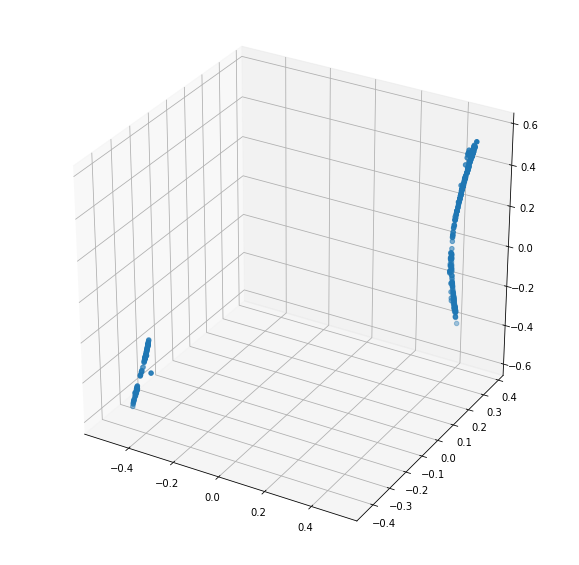

In [21]:
argmax = get_bestP2(pts1, pts2, P1, P2, R2, t)
print('Best P2 index:', argmax)
X = triangulate(pts1, pts2, P1, P2[argmax])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

In [22]:
np.savetxt("3dpoint.csv", X, delimiter=",")
np.savetxt("2dpoint.csv", pts1, delimiter=",")
np.savetxt("cameraMatrix.csv", cameraM, delimiter=",")